In [18]:
# class RobotabilityGraph that inherits from Graph class 
import os
import sys 
sys.path.append("/share/ju/urban-fingerprinting")

import osmnx as ox 
import geopandas as gpd 
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
# enable latex plotting 
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

from glob import glob 
from tqdm import tqdm 

from shapely import wkt, LineString 

import rasterio
from rasterio.enums import Resampling
from rasterio.plot import show 


from src.utils.logger import setup_logger 

logger = setup_logger('robotability-score')
logger.setLevel("INFO")
logger.info("Modules initialized.")

WGS='EPSG:4326'
PROJ='EPSG:2263'

REGEN_SEGMENTIZATION=True
REGEN_TOPOLOGY=True



2024-09-04 20:54:01 - robotability-score - INFO - Modules initialized.


In [41]:
ntas_nyc = gpd.read_file("../data/2020 Neighborhood Tabulation Areas (NTAs)/geo_export_ec7bcc3d-bf45-4337-8767-b0dd7fe592a8.shp", crs=WGS).to_crs(PROJ)

In [19]:
cbs_nyc = gpd.read_file("../data/nycb2020_24c/nycb2020.shp")
all_cbs_nyc = cbs_nyc.copy()

In [20]:
score_nyc = pd.read_csv("../data/processed/score_nyc_trashbot.csv", engine='pyarrow')

<Axes: >

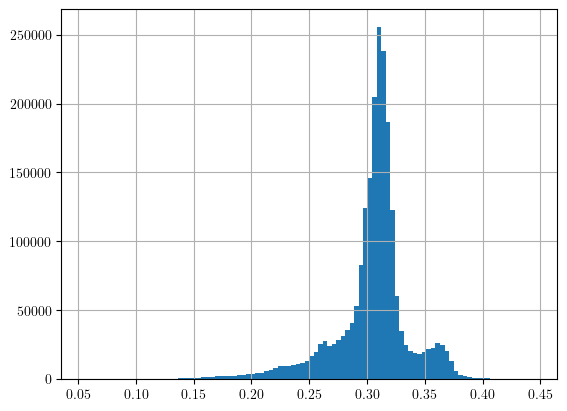

In [21]:
score_nyc['score'].hist(bins=100)

In [22]:
# compute score relative to average in score_rta column 
score_nyc['score_rta'] = score_nyc['score'] / score_nyc['score'].mean()
score_nyc['score_rta'].describe() 

count    2.164456e+06
mean     1.000000e+00
std      1.063311e-01
min      1.800362e-01
25%      9.733453e-01
50%      1.015436e+00
75%      1.044867e+00
max      1.460286e+00
Name: score_rta, dtype: float64

In [35]:
# how many times larger is the largest score than the minimum score 
score_nyc['score'].max() / score_nyc['score'].min()

2.695759944358086

In [23]:
score_nyc['score'].describe([0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.975, 0.99])

# clip between 0.01 and 0.99 percentiles 
score_nyc = score_nyc[(score_nyc['score'] > score_nyc['score'].quantile(0.001)) & (score_nyc['score'] < score_nyc['score'].quantile(0.999))]

In [24]:
score_nyc['score_percentile'] = score_nyc['score'].rank(pct=True) * 100
score_nyc['score_percentile'].describe()

count    2.160126e+06
mean     5.000002e+01
std      2.886752e+01
min      4.629360e-05
25%      2.500003e+01
50%      5.000002e+01
75%      7.500001e+01
max      1.000000e+02
Name: score_percentile, dtype: float64

In [25]:
score_nyc = gpd.GeoDataFrame(score_nyc, geometry=wkt.loads(score_nyc['geometry']), crs=PROJ)

In [26]:
score_nyc['score'].describe()

count    2.160126e+06
mean     3.049085e-01
std      3.183692e-02
min      1.470732e-01
25%      2.967552e-01
50%      3.095456e-01
75%      3.184945e-01
max      3.964739e-01
Name: score, dtype: float64

In [27]:
# merge score_nyc with cbs_nyc 
by_cb = score_nyc.sjoin(cbs_nyc, how='left', op='intersects')



/share/ju/conda_virtualenvs/urbanekg/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [28]:
score_by_cb = by_cb.groupby('BCTCB2020').agg({'score':'mean', 'score_rta':'mean', 'score_percentile': 'mean'}).reset_index()

In [36]:
score_by_cb['score'].max() / score_by_cb['score'].min()

2.4468506039848035

In [29]:
cbs_nyc = cbs_nyc.merge(score_by_cb, on='BCTCB2020', suffixes=('', '_mean'))

In [46]:
by_nta = score_nyc.sjoin(ntas_nyc, how='left', op='intersects')
score_by_nta = by_nta.groupby('ntaname').agg({'score':'mean', 'score_rta':'mean', 'score_percentile': 'mean'}).reset_index()

/share/ju/conda_virtualenvs/urbanekg/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [47]:
score_by_nta['score'].max() / score_by_nta['score'].min()

1.7609886317778278

/tmp/ipykernel_1997642/3548671292.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlGn')
/tmp/ipykernel_1997642/3548671292.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_xticklabels([str(int(tick)) + r'\textsuperscript{th}' for tick in cbar.get_xticks()])


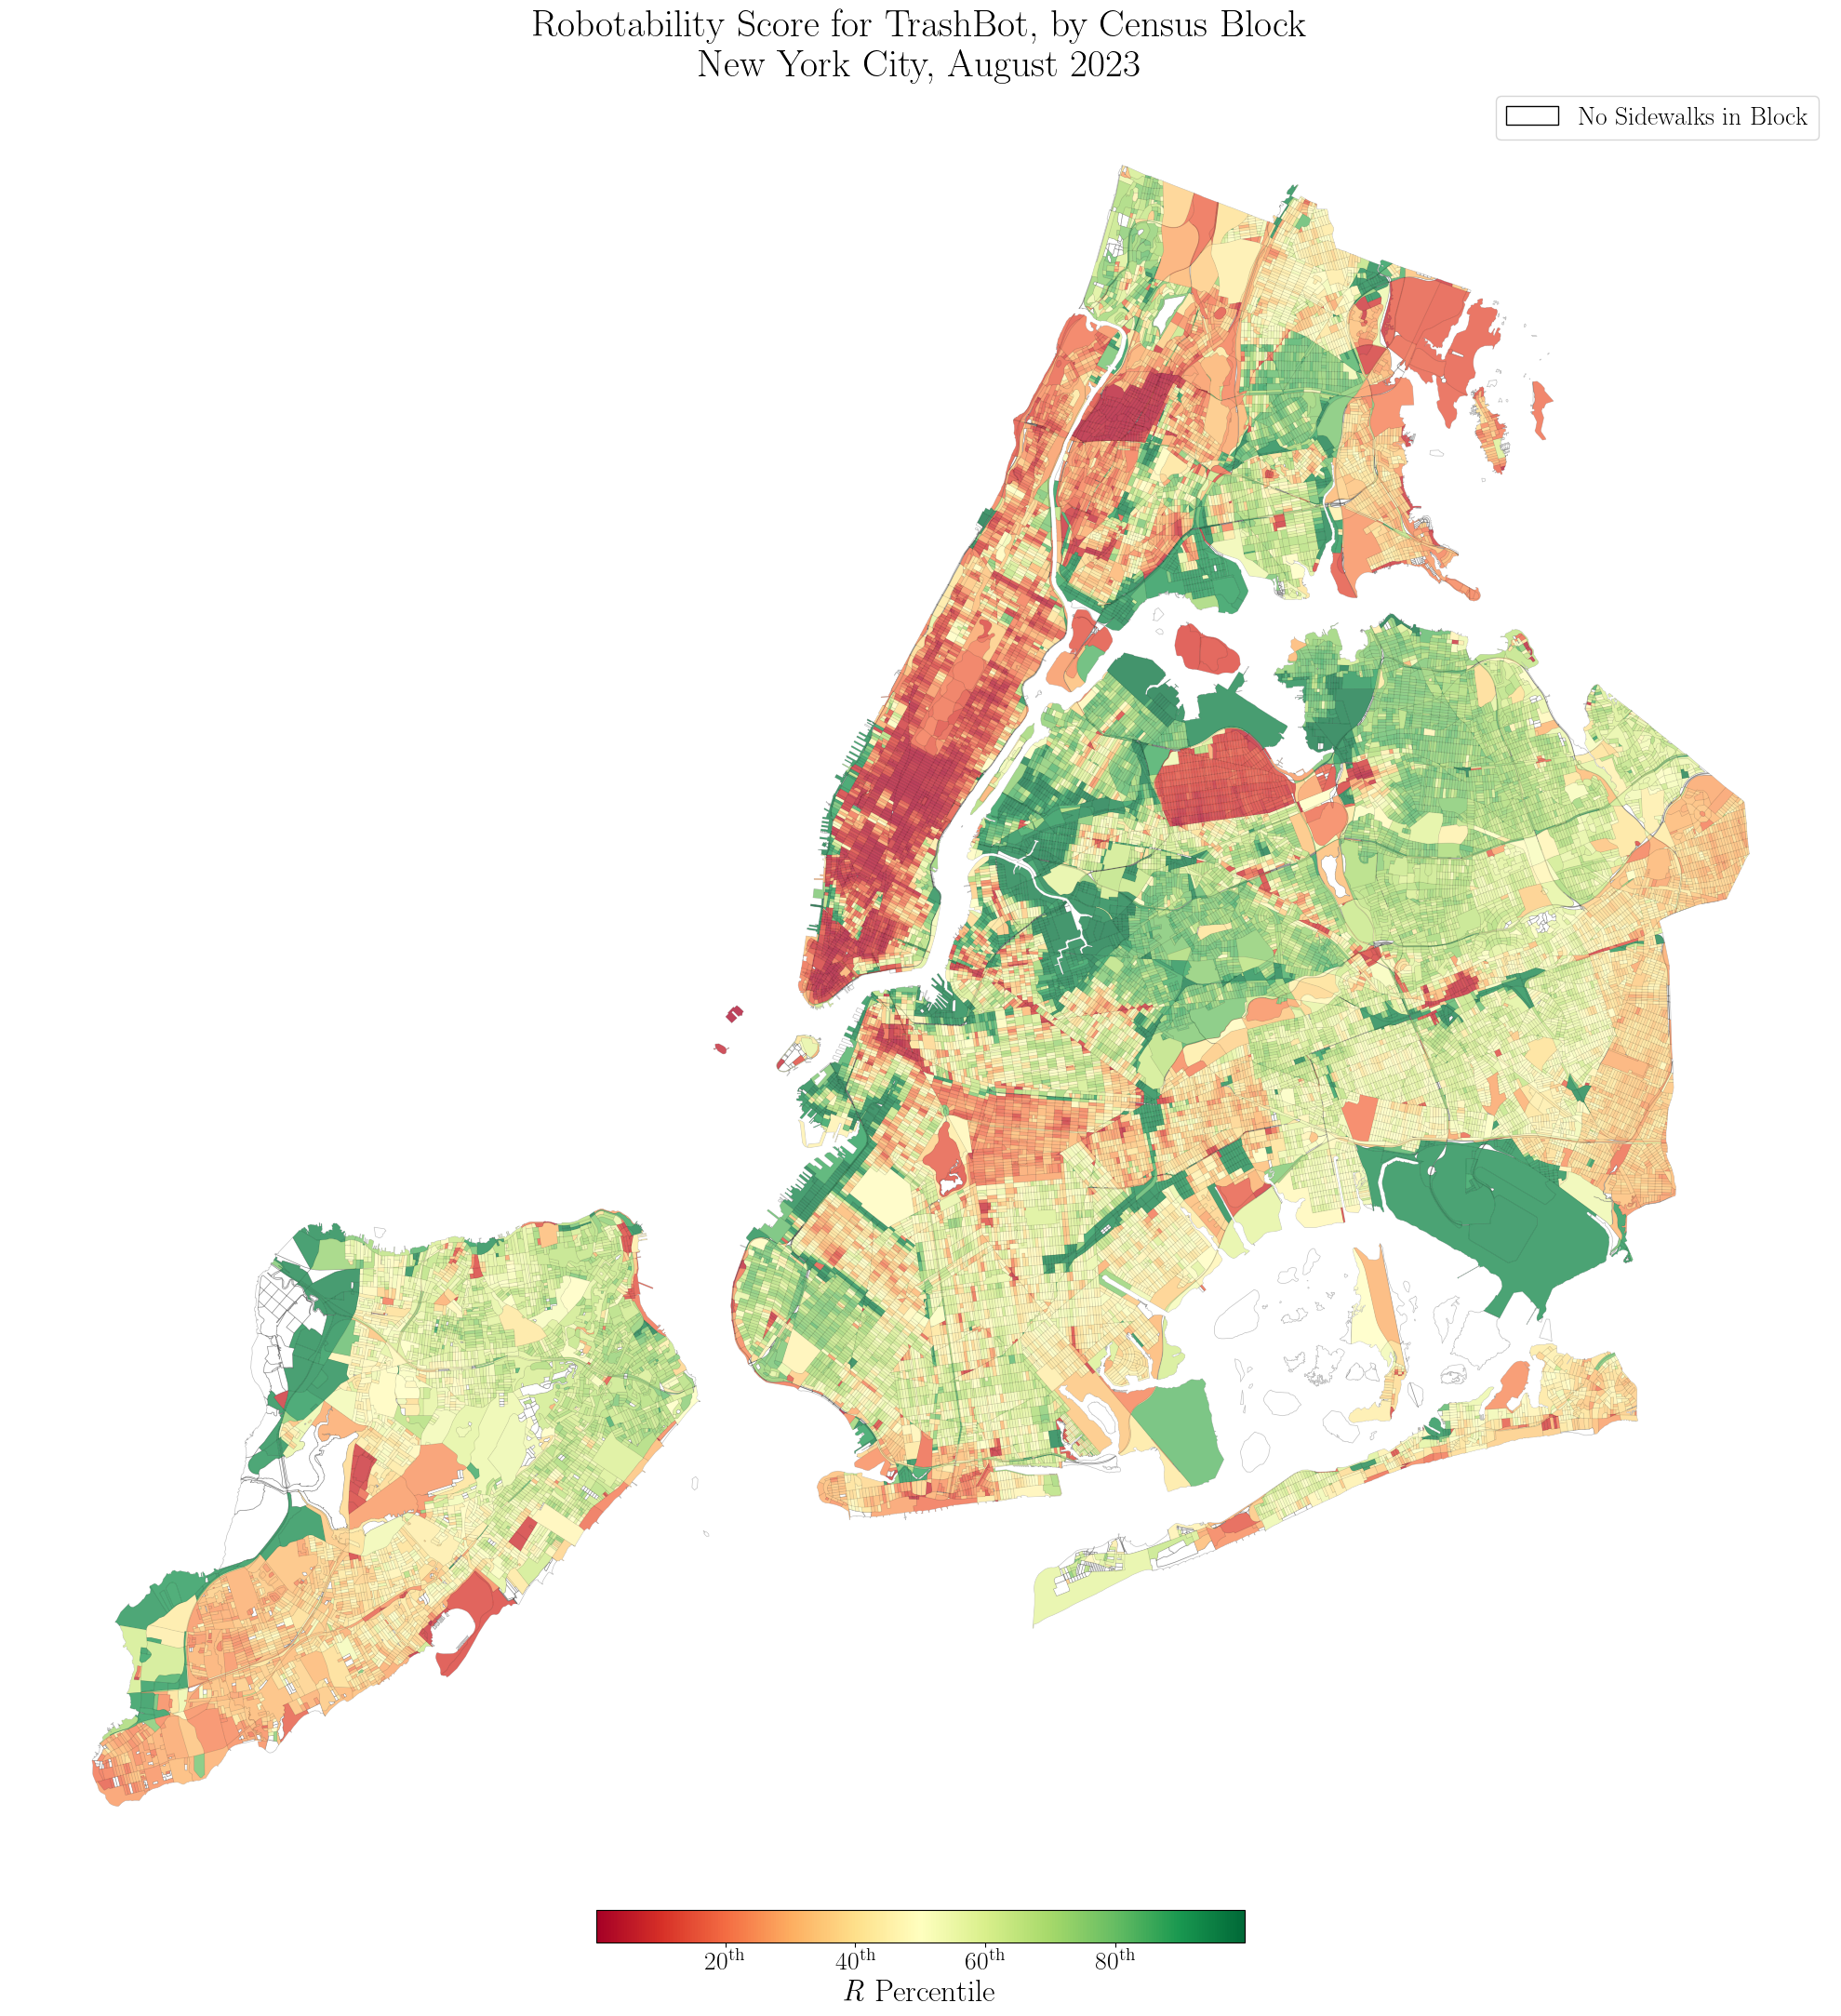

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(30, 30))

# get coolwarm colormap and inverse it 
cmap = plt.cm.get_cmap('RdYlGn')
#cmap = cmap.reversed()

all_cbs_nyc.boundary.plot(ax=ax, color='black', linewidth=0.5, alpha=0.25, zorder=0)
cbs_nyc.plot(column='score_percentile', ax=ax, legend=True, cmap=cmap, legend_kwds={'orientation': "horizontal", 'shrink': 0.3, 'pad': 0.01}, zorder=1, alpha=0.75),

# set colorbar font size 
cbar = ax.get_figure().get_axes()[1]
cbar.tick_params(labelsize=20)
# set label font size on colorbar 
cbar.set_xlabel(r"\textit{R} Percentile", fontsize=24)

# add 'th' to the end of the percentile for each tick label 
cbar.set_xticklabels([str(int(tick)) + r'\textsuperscript{th}' for tick in cbar.get_xticks()])

plt.title("Robotability Score for TrashBot, by Census Block" "\n" "New York City, August 2023", fontsize=30)

# add legend for blank census blocks 
from matplotlib.patches import Patch

legend_elements = [Patch(facecolor='white', edgecolor='black', label='No Sidewalks in Block')]

ax.legend(handles=legend_elements, loc='upper right', fontsize=20)

ax.set_axis_off()

plt.savefig("../figures/robotability_score_by_cb_trashbot.png", dpi=450, bbox_inches='tight')

In [31]:
# top ten census blocks 
top_ten = cbs_nyc.sort_values('score_percentile', ascending=False).head(10)
top_ten['latitude'] = top_ten.centroid.y
top_ten['longitude'] = top_ten.centroid.x
top_ten = top_ten[['BCTCB2020', 'score_percentile', 'latitude', 'longitude']]
top_ten = gpd.GeoDataFrame(top_ten, geometry=gpd.points_from_xy(top_ten.longitude, top_ten.latitude), crs=PROJ)
print(top_ten)

         BCTCB2020  score_percentile       latitude     longitude  \
35283  20028001006         99.952318  239223.401936  1.017398e+06   
32124  30021002026         99.949818  194638.578873  9.878143e+05   
35284  20028001011         99.946531  239057.714365  1.016520e+06   
20216  20028001009         99.944934  239160.251287  1.016503e+06   
25922  30018011001         99.929587  182633.906105  9.852169e+05   
25950  30053031001         99.927828  188803.589285  9.821125e+05   
14455  40479002002         99.927504  208373.137813  1.015609e+06   
31294  30059002004         99.833209  187940.954431  9.826752e+05   
20934  20165001010         99.800178  246598.447135  1.011461e+06   
31858  30059002009         99.790762  187819.115916  9.825308e+05   

                             geometry  
35283  POINT (1017398.065 239223.402)  
32124   POINT (987814.321 194638.579)  
35284  POINT (1016520.488 239057.714)  
20216  POINT (1016503.238 239160.251)  
25922   POINT (985216.916 182633.906)  


In [32]:
# bottom ten 
bottom_ten = cbs_nyc.sort_values('score_percentile', ascending=True).head(10)
bottom_ten['latitude'] = bottom_ten.centroid.y
bottom_ten['longitude'] = bottom_ten.centroid.x
bottom_ten = bottom_ten[['BCTCB2020', 'score_percentile', 'latitude', 'longitude']]
bottom_ten = gpd.GeoDataFrame(bottom_ten, geometry=gpd.points_from_xy(bottom_ten.longitude, bottom_ten.latitude), crs=PROJ)
print(bottom_ten)

         BCTCB2020  score_percentile       latitude     longitude  \
414    10030012003          0.142368  201968.031016  9.871767e+05   
1007   10073006005          0.161170  206719.873393  9.834974e+05   
1457   10113001008          0.196120  214291.075357  9.877915e+05   
5124   20237031002          0.199853  253366.007731  1.012231e+06   
5123   20237031001          0.214144  253341.346142  1.012452e+06   
1039   10076001002          0.216106  212072.153621  9.874967e+05   
657    10043001003          0.232476  203267.847933  9.855311e+05   
20372  20237031000          0.242328  253312.849879  1.012591e+06   
431    10031001006          0.251511  200713.509858  9.834235e+05   
35143  20237021005          0.294839  252498.605521  1.012418e+06   

                             geometry  
414     POINT (987176.728 201968.031)  
1007    POINT (983497.373 206719.873)  
1457    POINT (987791.491 214291.075)  
5124   POINT (1012231.415 253366.008)  
5123   POINT (1012452.409 253341.346)  


In [33]:
top_ten.to_crs(WGS).to_csv("../data/processed/top_ten_cb_trashbot.csv", index=False)
bottom_ten.to_crs(WGS).to_csv("../data/processed/bottom_ten_cb_trashbot.csv", index=False)

/tmp/ipykernel_1997642/1873118140.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlGn')


/tmp/ipykernel_1997642/1873118140.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_xticklabels([str(int(tick)) + r'\textsuperscript{th}' for tick in cbar.get_xticks()])


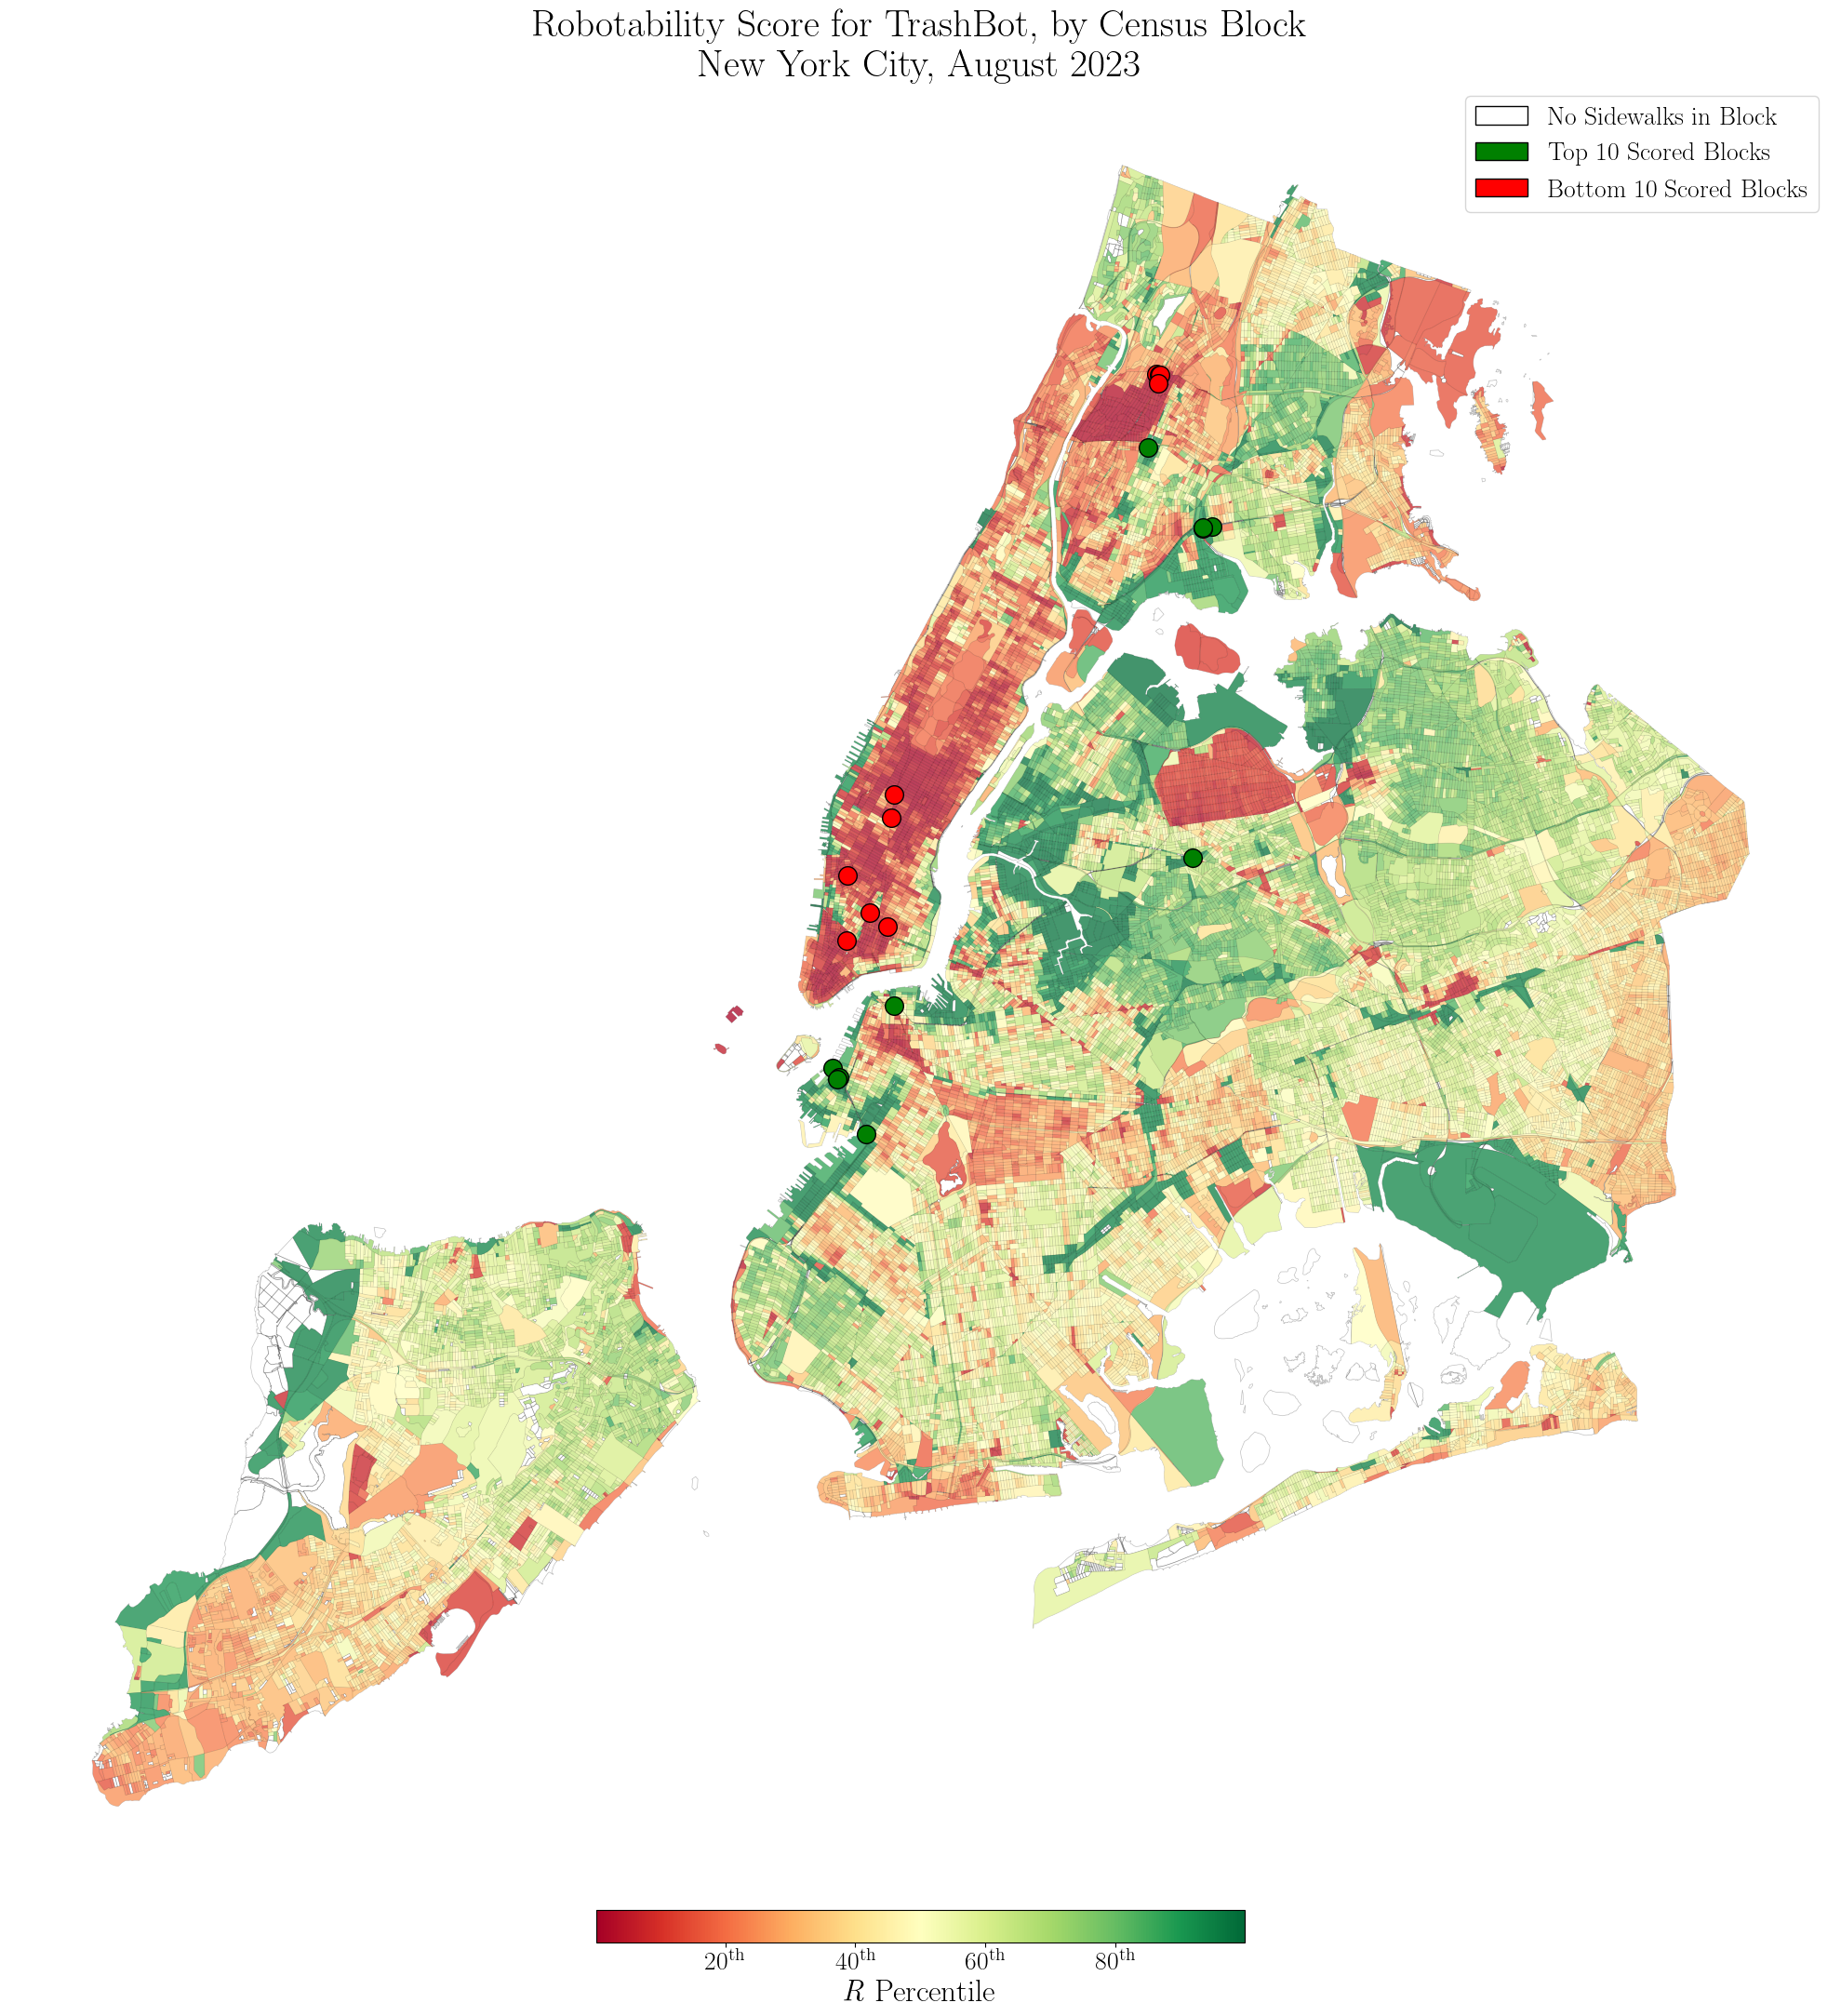

In [34]:
# new map and plot the top 10 and bottom 10 as bigger markers 
fig, ax = plt.subplots(1, 1, figsize=(30, 30))

# get coolwarm colormap and inverse it 
cmap = plt.cm.get_cmap('RdYlGn')
#cmap = cmap.reversed()

all_cbs_nyc.boundary.plot(ax=ax, color='black', linewidth=0.5, alpha=0.25, zorder=0)
cbs_nyc.plot(column='score_percentile', ax=ax, legend=True, cmap=cmap, legend_kwds={'orientation': "horizontal", 'shrink': 0.3, 'pad': 0.01}, zorder=1, alpha=0.75),


top_ten.plot(ax=ax, color='green', markersize=200, zorder=2, edgecolor='black')
bottom_ten.plot(ax=ax, color='red', markersize=200, zorder=2, edgecolor='black')

# set colorbar font size 
cbar = ax.get_figure().get_axes()[1]
cbar.tick_params(labelsize=20)
# set label font size on colorbar 
cbar.set_xlabel(r"\textit{R} Percentile", fontsize=24)

# add 'th' to the end of the percentile for each tick label 
cbar.set_xticklabels([str(int(tick)) + r'\textsuperscript{th}' for tick in cbar.get_xticks()])

plt.title("Robotability Score for TrashBot, by Census Block" "\n" "New York City, August 2023", fontsize=30)

# add legend for blank census blocks 
from matplotlib.patches import Patch

legend_elements = [Patch(facecolor='white', edgecolor='black', label='No Sidewalks in Block'),
                    Patch(facecolor='green', edgecolor='black', label='Top 10 Scored Blocks'),
                    Patch(facecolor='red', edgecolor='black', label='Bottom 10 Scored Blocks')]

ax.legend(handles=legend_elements, loc='upper right', fontsize=20)

ax.set_axis_off()

plt.savefig("../figures/robotability_score_by_cb_trashbot.png", dpi=450, bbox_inches='tight')
    